In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import tensorflow 
%matplotlib inline

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and spam messages')

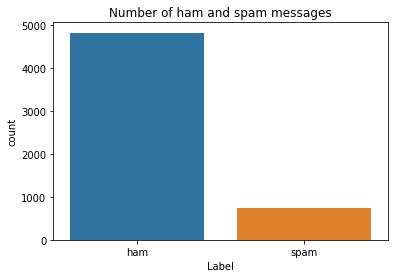

In [6]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [7]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [9]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)


In [10]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [11]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [12]:
df.columns

Index(['v1', 'v2'], dtype='object')

In [13]:
data=df.rename(
{
    "v1":"Category",
    "v2":"Message"
},
    axis=1
)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [15]:
data["Message Length"]=data["Message"].apply(len)

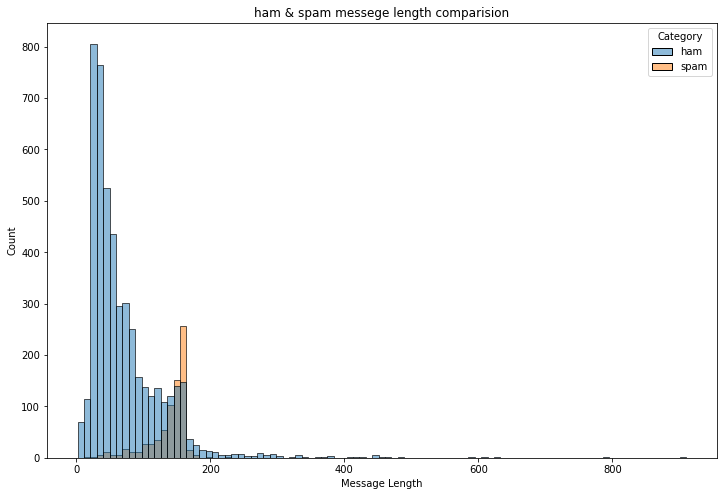

In [16]:
fig=plt.figure(figsize=(12,8))
sns.histplot(
    x=data["Message Length"],
    hue=data["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

In [ ]:
ham_desc=data[data["Category"]=="ham"]["Message Length"].describe()
spam_desc=data[data["Category"]=="spam"]["Message Length"].describe()

print("Ham Messege Length Description:\n",ham_desc)
print("************************************")
print("Spam Message Length Description:\n",spam_desc)

In [18]:
data.describe(include="all")

,Category,Message,Message Length
count,5572,5572,5572.000000
unique,2,5169,NaN
top,ham,"Sorry, I'll call later",NaN
freq,4825,30,NaN
mean,NaN,NaN,80.118808
std,NaN,NaN,59.690841
min,NaN,NaN,2.000000
25%,NaN,NaN,36.000000
50%,NaN,NaN,61.000000
75%,NaN,NaN,121.000000


In [19]:
data["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

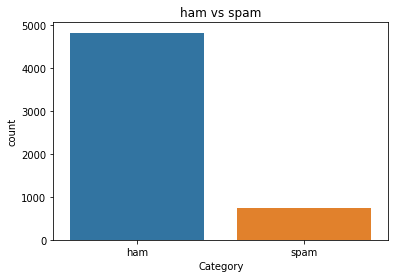

In [20]:
sns.countplot(
    data=data,
    x="Category"
)
plt.title("ham vs spam")
plt.show()


In [21]:
ham_count=data["Category"].value_counts()[0]
spam_count=data["Category"].value_counts()[1]

total_count=data.shape[0]

print("Ham contains:{:.2f}% of total data.".format(ham_count/total_count*100))
print("Spam contains:{:.2f}% of total data.".format(spam_count/total_count*100))

Ham contains:86.59% of total data.
Spam contains:13.41% of total data.


In [22]:
minority_len=len(data[data["Category"]=="spam"])
majority_len=len(data[data["Category"]=="ham"])
minority_indices=data[data["Category"]=="spam"].index
majority_indices=data[data["Category"]=="ham"].index
random_majority_indices=np.random.choice(
    majority_indices,
    size=minority_len,
    replace=False
)
undersampled_indices=np.concatenate([minority_indices,random_majority_indices])
df=data.loc[undersampled_indices]
df=df.sample(frac=1)

df=df.reset_index()
df=df.drop(
    columns=["index"],
)

In [23]:
df.shape

(1494, 3)

In [24]:
df["Category"].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

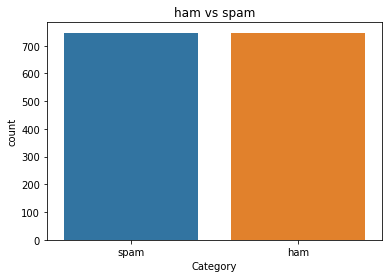

In [25]:
sns.countplot(
    data=df,
    x="Category"
)
plt.title("ham vs spam")
plt.show()

In [26]:
df.head()

,Category,Message,Message Length
0,spam,"Dear Voucher Holder, To claim this weeks offer...",152
1,ham,I cant pick the phone right now. Pls send a me...,51
2,spam,TheMob>Hit the link to get a premium Pink Pant...,149
3,spam,URGENT This is our 2nd attempt to contact U. Y...,136
4,spam,"449050000301 You have won a å£2,000 price! To ...",70


In [27]:
df["Label"]=df["Category"].map(
    {
        "ham":0,
        "spam":1
    }
)

In [28]:
df.head()

,Category,Message,Message Length,Label
0,spam,"Dear Voucher Holder, To claim this weeks offer...",152,1
1,ham,I cant pick the phone right now. Pls send a me...,51,0
2,spam,TheMob>Hit the link to get a premium Pink Pant...,149,1
3,spam,URGENT This is our 2nd attempt to contact U. Y...,136,1
4,spam,"449050000301 You have won a å£2,000 price! To ...",70,1


In [29]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer=PorterStemmer()

In [30]:
corpus=[]
for message in df["Message"]:
    message=re.sub("[^a-zA-Z]"," ",message)
    message=message.lower()
    message=message.split()
    
   

In [31]:
from tensorflow.keras.preprocessing.text import one_hot
vocab_size=10000

oneHot_doc=[one_hot(words,n=vocab_size)
           for words in corpus
           ]

In [32]:
df["Message Length"].describe()

count    1494.000000
mean      105.296519
std        57.379967
min         2.000000
25%        49.000000
50%       120.000000
75%       153.000000
max       450.000000
Name: Message Length, dtype: float64

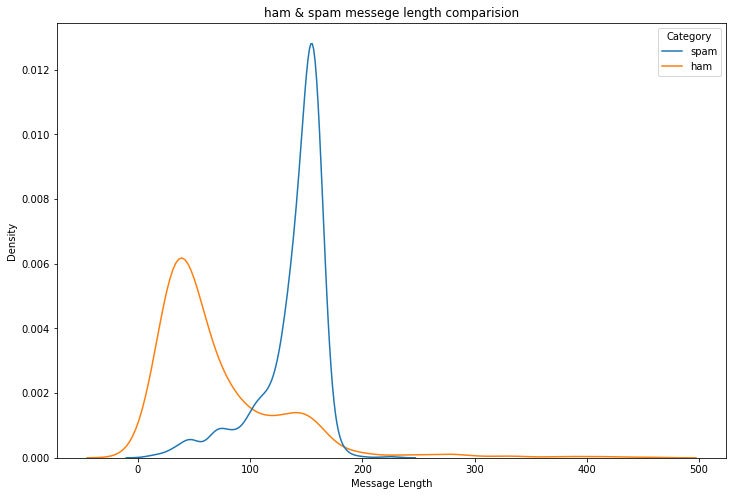

In [33]:
fig=plt.figure(figsize=(12,8))
sns.kdeplot(
    x=df["Message Length"],
    hue=df["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sentence_len=200
embedded_doc=pad_sequences(
    oneHot_doc,
    maxlen=sentence_len,
    padding="pre"
)

In [35]:
extract_features=pd.DataFrame(
    data=embedded_doc
)
target=df["Label"]

In [36]:
df_final=pd.concat([extract_features,target],axis=1)

In [37]:
df_final.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Label
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [38]:
X=df_final.drop("Label",axis=1)
y=df_final["Label"]

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_trainval,X_test,y_trainval,y_test=train_test_split(
    X,
    y,
    random_state=42,
    test_size=0.15
)

In [41]:
X_train,X_val,y_train,y_val=train_test_split(
    X_trainval,
    y_trainval,
    random_state=42,
    test_size=0.15
)

In [42]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 